In [1]:
# import libraries
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
import inspect
import time

# access parent directory from notebooks directory
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

import newsrc.simulation as s

%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload

In [2]:
try:
    input_args = json.loads(open('../input/simulation.json').read())
except Exception as ex:
    print('simulation.json does not exist!')
    print(ex)


In [3]:
# instantiate simulation class

simulation =  s.Simulation()

/Users/davidblok/Work EUR/GitHub/ABM-PA/newsrc/simulation.py:28: DtypeWarning: Columns (319,321,323,377,434,436,439,441,444,446,449,451,454,456,459,461,464,466,469,471,474,476,479,481,484,486,489,491) have mixed types.Specify dtype option on import or set low_memory=False.
  self.PeerNominatedDataPopulation = p.PeerNominatedDataPopulation('Peer-Nominated data population', self.input_args)
<ipython-input-3-cc89a67aeca7>:1: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  simulation =  s.Simulation()
/Users/davidblok/Work EUR/GitHub/ABM-PA/newsrc/simulation.py:29: DtypeWarning: Columns (319,321,323,377,434,436,439,441,444,446,449,451,454,456,459,461,464,466,469,471,474,476,479,481,484,486,489,491) have mixed types.Specify dtype option on import or set low_memory=False.
  self.CommunicationDataPopulation = p.CommunicationDataPopulation('Communication data population', self.input_args)


# Simulation Interventions

## 1. Nomination network

In [ ]:
# Read tuned parameter combinations (See tuning_nom_network.ipynb)
pars_nomination = pd.read_csv('../output/opt_pars_nominated.csv', sep=',', header=0)
pars_nomination

In [ ]:
# Run simulations for each parameter combination
list_results_nomm = []
list_results_avg_nomm = []
list_agents_per_intervention_nomm = []
start_whole = time.time()
count = 0
for index, row in pars_nomination.iterrows():
    results_nomm, results_avg_nomm, agents_per_intervention_nomm = simulation.simulate_interventions(700,'peer',row['threshold'],row['ipa'])
    list_results_nomm.append(results_nomm)
    list_results_avg_nomm.append(results_avg_nomm)
    list_agents_per_intervention_nomm.append(agents_per_intervention_nomm)
    end = time.time()
    print(count, row['threshold'], row['ipa'], "Time elapsed:", end - start_whole, ' seconds')
    count = count + 1


# 2. Communication network


In [ ]:
# Read tuned parameter combinations (See tuning_com_network.ipynb)
pars_communication = pd.read_csv('../output/opt_pars_communication.csv', sep=',', header=0, encoding='latin-1')
pars_communication

In [ ]:
# Run simulations for each parameter combination
list_results_comm = []
list_results_avg_comm = []
list_agents_per_intervention_comm = []
start_whole = time.time()
count = 0
for index, row in pars_communication.iterrows():
    results_comm, results_avg_comm, agents_per_intervention_comm = simulation.simulate_interventions(700,'communication',row['threshold'],row['ipa'])
    list_results_comm.append(results_comm)
    list_results_avg_comm.append(results_avg_comm)
    list_agents_per_intervention_comm.append(agents_per_intervention_comm)
    end = time.time()
    print(count, row['threshold'], row['ipa'], "Time elapsed:", end - start_whole, ' seconds')
    count = count + 1

# Ploting the outcomes

## New method (also for percentile)

In [65]:
# Step1: create a list per run of overall mean PAL

# Nomination network
list_results_mean_nom = []
for run in range(len(list_results_avg_nomm)):
    # per run mean of all classes
    all_averaged = {}
    for i in input_args['intervention_strategy']:
        temp_res = pd.Series([], dtype = float)
        counter = 0
        for class_id,res in list_results_avg_nomm[run].items():
            temp_res = temp_res.add(list_results_avg_nomm[run][class_id][i],fill_value=0)
            counter = counter + 1
        all_averaged[i] = temp_res/counter

    list_results_mean_nom.append(all_averaged)



# Communication network
list_results_mean_com = []
for run in range(len(list_results_avg_comm)):
    # per run mean of all classes
    all_averaged = {}
    for i in input_args['intervention_strategy']:
        temp_res = pd.Series([], dtype = float)
        counter = 0
        for class_id,res in list_results_avg_comm[run].items():
            temp_res = temp_res.add(list_results_avg_comm[run][class_id][i],fill_value=0)
            counter = counter + 1
        all_averaged[i] = temp_res/counter

    list_results_mean_com.append(all_averaged)


In [75]:
# Step2: Creat per intervention a list of 100

# Nomination network
out_indegree_nom = []
out_betweenness_nom = []
out_closeness_nom = []

for run in range(len(list_results_mean_nom)):
    # per run
    temp1 = list_results_mean_nom[run]
    out_indegree_nom.append(temp1['indegree'])
    out_betweenness_nom.append(temp1['betweenness'])
    out_closeness_nom.append(temp1['closeness'])


# Comunication network
out_indegree_com = []
out_betweenness_com = []
out_closeness_com = []

for run in range(len(list_results_mean_com)):
    # per run
    temp1 = list_results_mean_com[run]
    out_indegree_com.append(temp1['indegree'])
    out_betweenness_com.append(temp1['betweenness'])
    out_closeness_com.append(temp1['closeness'])


In [78]:
# Step3: calculate mean and percentiles

# list into dataframe

# Nomination network
results_nom_indegree = pd.concat(out_indegree_nom, axis=1, keys=[s.name for s in out_indegree_nom])
results_nom_betweenness = pd.concat(out_betweenness_nom, axis=1, keys=[s.name for s in out_betweenness_nom])
results_nom_closeness = pd.concat(out_closeness_nom, axis=1, keys=[s.name for s in out_closeness_nom])

# indegree
i_nom = results_nom_indegree.mean(axis=1)
i_nom_min = results_nom_indegree.quantile(q=0.025, axis=1)
i_nom_max = results_nom_indegree.quantile(q=0.975, axis=1)

# betweenness
b_nom = results_nom_betweenness.mean(axis=1)
b_nom_min = results_nom_betweenness.quantile(q=0.025, axis=1)
b_nom_max = results_nom_betweenness.quantile(q=0.975, axis=1)

# closeness
c_nom = results_nom_closeness.mean(axis=1)
c_nom_min = results_nom_closeness.quantile(q=0.025, axis=1)
c_nom_max = results_nom_closeness.quantile(q=0.975, axis=1)


# Comunication network
results_com_indegree = pd.concat(out_indegree_com, axis=1, keys=[s.name for s in out_indegree_com])
results_com_betweenness = pd.concat(out_betweenness_com, axis=1, keys=[s.name for s in out_betweenness_com])
results_com_closeness = pd.concat(out_closeness_com, axis=1, keys=[s.name for s in out_closeness_com])

# indegree
i_com = results_com_indegree.mean(axis=1)
i_com_min = results_com_indegree.quantile(q=0.025, axis=1)
i_com_max = results_com_indegree.quantile(q=0.975, axis=1)

# betweenness
b_com = results_com_betweenness.mean(axis=1)
b_com_min = results_com_betweenness.quantile(q=0.025, axis=1)
b_com_max = results_com_betweenness.quantile(q=0.975, axis=1)

# closeness
c_com = results_com_closeness.mean(axis=1)
c_com_min = results_com_closeness.quantile(q=0.025, axis=1)
c_com_max = results_com_closeness.quantile(q=0.975, axis=1)

In [147]:
# Success rate (only mean)

# Nomination network
i_nom_sr = (i_nom/i_nom[0] -1) *100
i_nom_sr_min = (i_nom_min/i_nom_min[0] -1) *100
i_nom_sr_max = (i_nom_max/i_nom_max[0] -1) *100
b_nom_sr = (b_nom/b_nom[0] -1) *100
b_nom_sr_min = (b_nom_min/b_nom_min[0] -1) *100
b_nom_sr_max = (b_nom_max/b_nom_max[0] -1) *100
c_nom_sr = (c_nom/c_nom[0] -1) *100
c_nom_sr_min = (c_nom_min/c_nom_min[0] -1) *100
c_nom_sr_max = (c_nom_max/c_nom_max[0] -1) *100

# Communication network
i_com_sr = (i_com/i_com[0] -1) *100
i_com_sr_min = (i_com_min/i_com_min[0] -1) *100
i_com_sr_max = (i_com_max/i_com_max[0] -1) *100
b_com_sr = (b_com/b_com[0] -1) *100
b_com_sr_min = (b_com_min/b_com_min[0] -1) *100
b_com_sr_max = (b_com_max/b_com_max[0] -1) *100
c_com_sr = (c_com/c_com[0] -1) *100
c_com_sr_min = (c_com_min/c_com_min[0] -1) *100
c_com_sr_max = (c_com_max/c_com_max[0] -1) *100


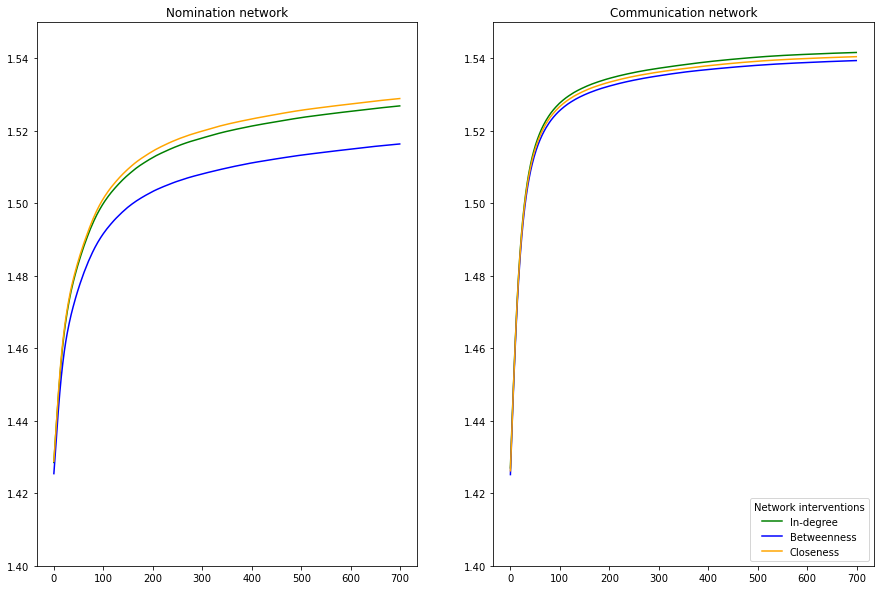

In [87]:
# Plots (with confidence intervals)
ticks = np.arange(1.40, 1.60, 0.01)
x = np.arange(0,700,1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))

ax1.set_title('Nomination network')
ax1.set_ylim([1.4, 1.55])
ax1.plot(x, i_nom, color='green')
#plt.fill_between(x, i_nom_min, i_nom_max, alpha=0.2, color='C5')
ax1.plot(x, b_nom, color='blue')
#plt.fill_between(x, b_nom_min, b_nom_max, alpha=0.2, color='C0')
ax1.plot(x, c_nom, color='orange')
#plt.fill_between(x, c_nom_min, c_nom_max, alpha=0.2, color='C3')

ax2.set_title('Communication network')
ax2.set_ylim([1.4, 1.55])
ax2.plot(x, i_com, color='green')
#plt.fill_between(x, i_com_min, i_com_max, alpha=0.2, color='C5')
ax2.plot(x, b_com, color='blue')
#plt.fill_between(x, b_com_min, b_com_max, alpha=0.2, color='C0')
ax2.plot(x, c_com, color='orange')
#plt.fill_between(x, c_com_min, c_com_max, alpha=0.2, color='C3')
ax2.legend(['In-degree', 'Betweenness', 'Closeness'], loc='lower right', title="Network interventions")

#fig.figsize=((16,14))
#plt.axis(xmin=0,xmax=700,ymin=1.4,ymax=1.6)
#plt.yticks(ticks)
#plt.ylabel('Mean physical activity level')
#plt.xlabel('Days')
#plt.legend(['In-Degree', 'Betweenness', 'Closeness'], loc='lower right', title="Network interventions")

fig.savefig('../output/sim_results1.png')


In [149]:
# confidence intervals at day 700
print('nom i:', i_nom_sr[699], 'b:', b_nom_sr[699], 'c: ', c_nom_sr[699])
print('nom min i:', i_nom_sr_min[699], 'b:', b_nom_sr_min[699], 'c: ', c_nom_sr_min[699])
print('nom max i:', i_nom_sr_max[699], 'b:', b_nom_sr_max[699], 'c: ', c_nom_sr_max[699])

print('com i:', i_com_sr[699], 'b:', b_com_sr[699], 'c: ', c_com_sr[699])
print('com min i:', i_com_sr_min[699], 'b:', b_com_sr_min[699], 'c: ', c_com_sr_min[699])
print('com max i:', i_com_sr_max[699], 'b:', b_com_sr_max[699], 'c: ', c_com_sr_max[699])

nom i: 6.887428739890922 b: 6.381933024204067 c:  7.005427221041582
nom min i: 3.243980271800506 b: 2.5021604817849985 c:  3.7307486546552804
nom max i: 8.436829934755274 b: 7.395782419539376 c:  8.667219778387025
com i: 8.032688653671617 b: 8.016044851911786 c:  8.012089610026152
com min i: 7.236467398007296 b: 7.245036613936429 c:  7.239217051780411
com max i: 8.427902504532847 b: 8.35344883186786 c:  8.385109250529887


In [144]:
c_com_sr

0      0.000000
1      0.270995
2      0.537930
3      0.810417
4      1.074172
         ...   
695    8.010883
696    8.011190
697    8.011490
698    8.011800
699    8.012090
Length: 700, dtype: float64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


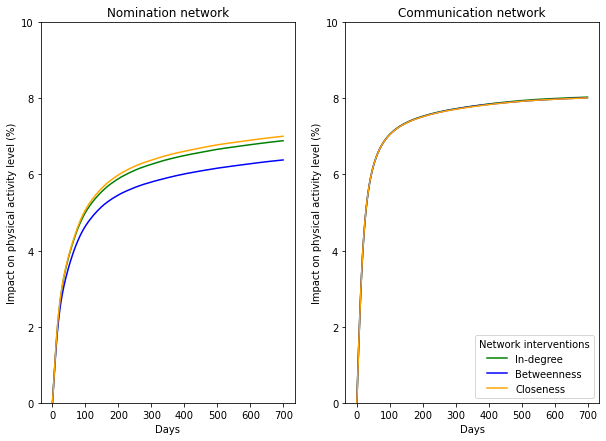

In [150]:
# Plots (with confidence intervals)
ticks = np.arange(1.40, 1.60, 0.01)
x = np.arange(0,700,1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))

ax1.set_title('Nomination network')
ax1.set_xlabel('Days')
ax1.set_ylabel('Impact on physical activity level (%)')
ax1.set_ylim([0, 10])
ax1.plot(x, i_nom_sr, color='green')
ax1.plot(x, b_nom_sr, color='blue')
ax1.plot(x, c_nom_sr, color='orange')

ax2.set_title('Communication network')
ax2.set_xlabel('Days')
ax2.set_ylabel('Impact on physical activity level (%)')
ax2.set_ylim([0, 10])
ax2.plot(x, i_com_sr, color='green')
ax2.plot(x, b_com_sr, color='blue')
ax2.plot(x, c_com_sr, color='orange')
ax2.legend(['In-degree', 'Betweenness', 'Closeness'], loc='lower right', title="Network interventions")

fig.savefig('../output/sim_results2.eps', bbox_inches='tight', format='eps', dpi=1000)


# Variation at day 700

In [104]:
nom_var = {'In-degree': (results_nom_indegree.iloc[699]/results_nom_indegree.iloc[0] -1) *100,
           'Betweenness': (results_nom_betweenness.iloc[699]/results_nom_betweenness.iloc[0] -1) *100,
           'Closeness': (results_nom_closeness.iloc[699]/results_nom_closeness.iloc[0] -1) *100}

com_var = {'In-degree': (results_com_indegree.iloc[699]/results_com_indegree.iloc[0] -1) *100,
           'Betweenness': (results_com_betweenness.iloc[699]/results_com_betweenness.iloc[0] -1) *100,
           'Closeness': (results_com_closeness.iloc[699]/results_com_closeness.iloc[0] -1) *100}


Could not connect to 127.0.0.1: 51384
Traceback (most recent call last):
  File "/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev/_pydevd_bundle/pydevd_comm.py", line 458, in start_client
    s.connect((host, port))
ConnectionRefusedError: [Errno 61] Connection refused
Traceback (most recent call last):
  File "/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug/pydev_jupyter_utils.py", line 63, in attach_to_debugger
    debugger.connect(pydev_localhost.get_localhost(), debugger_port)
  File "/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev/pydevd.py", line 655, in connect
    s = start_client(host, port)
  File "/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev/_pydevd_bundle/pydevd_comm.py", line 458, in start_client
    s.connect((host, port))
ConnectionRefusedError: [Errno 61] Connection refused
Failed to connect to target debugger.


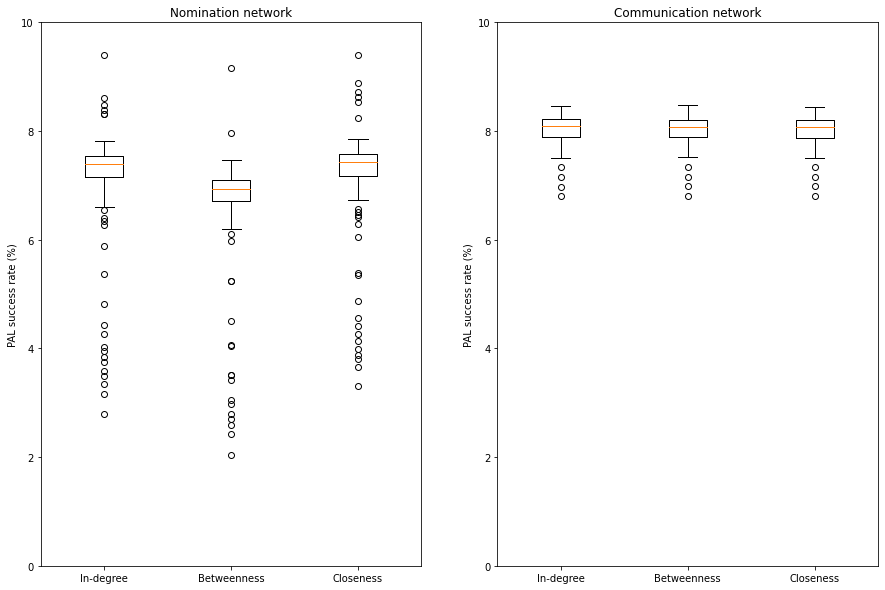

In [108]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))

ax1.set_title('Nomination network')
ax1.set_ylabel('PAL success rate (%)')
ax1.set_ylim([0, 10])
ax1.boxplot(nom_var.values())
ax1.set_xticklabels(nom_var.keys())


ax2.set_title('Communication network')
ax2.set_ylabel('PAL success rate (%)')
ax2.set_ylim([0, 10])
ax2.boxplot(com_var.values())
ax2.set_xticklabels(com_var.keys())
#ax2.legend(['In-degree', 'Betweenness', 'Closeness'], loc='lower right', title="Network interventions")


fig.savefig('../output/sim_results3.png', bbox_inches='tight')



In [109]:
# Nomination network
all_averaged_nomm = {}
for class_id in input_args['classes']:
    all_averaged_nomm[str(class_id)] = {}
    for i in  ['betweenness','closeness','indegree']:
        temp_res = pd.Series([], dtype = float)
        count_res = 0
        for res_avg in list_results_avg_nomm:
            temp_res = temp_res.add(res_avg[str(class_id)][i],fill_value=0)
            count_res = count_res + 1
        all_averaged_nomm[str(class_id)][i] = temp_res/count_res

# Communication network
all_averaged_comm = {}
for class_id in input_args['classes']:
    all_averaged_comm[str(class_id)] = {}
    for i in  ['betweenness','closeness','indegree']:
        temp_res = pd.Series([], dtype = float)
        count_res = 0
        for res_avg in list_results_avg_comm:
            temp_res = temp_res.add(res_avg[str(class_id)][i],fill_value=0)
            count_res = count_res + 1
        all_averaged_comm[str(class_id)][i] = temp_res/count_res

In [118]:

# Nomination network
class_indegree_nom = []
class_betweenness_nom = []
class_closeness_nom = []

for c in input_args['classes']:
    # per run
    temp1 = all_averaged_nomm[str(c)]
    class_indegree_nom.append(temp1['indegree'])
    class_betweenness_nom.append(temp1['betweenness'])
    class_closeness_nom.append(temp1['closeness'])

# Communication network
class_indegree_com = []
class_betweenness_com = []
class_closeness_com = []

for c in input_args['classes']:
    # per run
    temp1 = all_averaged_comm[str(c)]
    class_indegree_com.append(temp1['indegree'])
    class_betweenness_com.append(temp1['betweenness'])
    class_closeness_com.append(temp1['closeness'])

In [124]:
# Comunication network
pd_class_indegree_nom = pd.concat(class_indegree_nom, axis=1, keys=[s.name for s in class_indegree_nom])
pd_class_betweenness_nom = pd.concat(class_betweenness_nom, axis=1, keys=[s.name for s in class_betweenness_nom])
pd_class_closeness_nom = pd.concat(class_closeness_nom, axis=1, keys=[s.name for s in class_closeness_nom])

In [ ]:
# Comunication network
pd_class_indegree_com = pd.concat(class_indegree_com, axis=1, keys=[s.name for s in class_indegree_com])
pd_class_betweenness_com = pd.concat(class_betweenness_com, axis=1, keys=[s.name for s in class_betweenness_com])
pd_class_closeness_com = pd.concat(class_closeness_com, axis=1, keys=[s.name for s in class_closeness_com])



In [125]:
nom_clvar = {'In-degree': (pd_class_indegree_nom.iloc[699]/pd_class_indegree_nom.iloc[0] -1) *100,
           'Betweenness': (pd_class_betweenness_nom.iloc[699]/pd_class_betweenness_nom.iloc[0] -1) *100,
           'Closeness': (pd_class_closeness_nom.iloc[699]/pd_class_closeness_nom.iloc[0] -1) *100}

com_clvar = {'In-degree': (pd_class_indegree_com.iloc[699]/pd_class_indegree_com.iloc[0] -1) *100,
           'Betweenness': (pd_class_betweenness_com.iloc[699]/pd_class_betweenness_com.iloc[0] -1) *100,
           'Closeness': (pd_class_closeness_com.iloc[699]/pd_class_closeness_com.iloc[0] -1) *100}



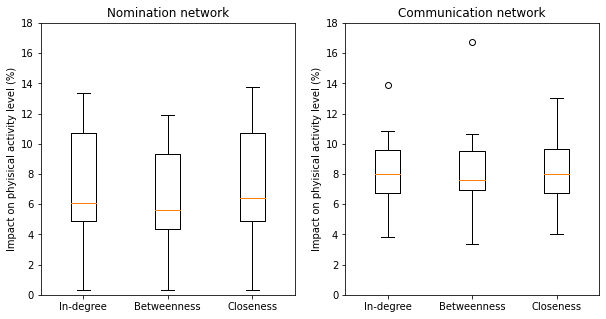

In [151]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('Nomination network')
ax1.set_ylabel('Impact on phyisical activity level (%)')
ax1.set_ylim([0, 18])
ax1.boxplot(nom_clvar.values())
ax1.set_xticklabels(nom_clvar.keys())


ax2.set_title('Communication network')
ax2.set_ylabel('Impact on phyisical activity level (%)')
ax2.set_ylim([0, 18])
ax2.boxplot(com_clvar.values())
ax2.set_xticklabels(com_clvar.keys())
#ax2.legend(['In-degree', 'Betweenness', 'Closeness'], loc='lower right', title="Network interventions")


fig.savefig('../output/sim_results4.eps', bbox_inches='tight', format='eps', dpi=1000)



In [159]:
i_nom_bp = (pd_class_indegree_nom.iloc[699]/pd_class_indegree_nom.iloc[0] -1) *100
b_nom_bp = (pd_class_betweenness_nom.iloc[699]/pd_class_betweenness_nom.iloc[0] -1) *100
c_nom_bp =  (pd_class_closeness_nom.iloc[699]/pd_class_closeness_nom.iloc[0] -1) *100

i_com_bp = (pd_class_indegree_com.iloc[699]/pd_class_indegree_com.iloc[0] -1) *100
b_com_bp = (pd_class_betweenness_com.iloc[699]/pd_class_betweenness_com.iloc[0] -1) *100
c_com_bp = (pd_class_closeness_com.iloc[699]/pd_class_closeness_com.iloc[0] -1) *100

In [164]:
com_clvar


{'In-degree': NaN     7.849834
 NaN     6.736012
 NaN     9.561016
 NaN     8.819963
 NaN     5.354492
 NaN     7.140796
 NaN     6.970233
 NaN     3.835821
 NaN     6.906339
 NaN    10.481696
 NaN     4.023694
 NaN    10.588082
 NaN     5.500869
 NaN     8.505945
 NaN    13.897532
 NaN     8.640485
 NaN     9.885924
 NaN    10.859243
 NaN     6.498755
 NaN     8.210558
 NaN     7.971481
 dtype: float64,
 'Betweenness': NaN     7.621993
 NaN     7.369291
 NaN    10.628382
 NaN     9.943455
 NaN     5.354492
 NaN     7.514880
 NaN     6.970233
 NaN     3.331968
 NaN     6.612207
 NaN     8.665145
 NaN     4.155965
 NaN     9.533120
 NaN     5.500869
 NaN     8.045051
 NaN    16.714025
 NaN     8.031089
 NaN     9.533485
 NaN    10.043277
 NaN     7.262451
 NaN     7.988974
 NaN     7.279733
 dtype: float64,
 'Closeness': NaN     7.621993
 NaN     6.736012
 NaN    11.302869
 NaN     7.999849
 NaN     5.354492
 NaN     7.415050
 NaN     6.970233
 NaN     4.170937
 NaN     6.906339
 NaN   

In [165]:
nom_clvar


{'In-degree': NaN     0.348243
 NaN    10.737845
 NaN     3.140071
 NaN     5.134581
 NaN     2.614880
 NaN     7.142449
 NaN    13.357336
 NaN     2.642418
 NaN     8.625006
 NaN     6.461696
 NaN     4.882662
 NaN     3.265018
 NaN     5.914686
 NaN     5.625947
 NaN    12.180251
 NaN    11.626785
 NaN     7.056034
 NaN    13.115164
 NaN     6.073162
 NaN     4.878565
 NaN    11.246346
 dtype: float64,
 'Betweenness': NaN     0.315972
 NaN    10.126807
 NaN     3.140071
 NaN     4.783857
 NaN     2.614880
 NaN     7.621485
 NaN    11.895609
 NaN     2.800926
 NaN     8.779130
 NaN     5.332593
 NaN     4.355027
 NaN     2.368075
 NaN     5.625901
 NaN     4.694253
 NaN    11.904140
 NaN     9.343764
 NaN     6.257756
 NaN    11.523275
 NaN     5.622173
 NaN     4.726273
 NaN    11.780303
 dtype: float64,
 'Closeness': NaN     0.348243
 NaN    10.737845
 NaN     3.140071
 NaN     5.134581
 NaN     2.614880
 NaN     7.090763
 NaN    13.789948
 NaN     3.791601
 NaN     8.625006
 NaN   

In [ ]:
# all_averaged = {}
# for i in ['betweenness','closeness','indegree']:
#     result_counter = 0
#     for res_avg in list_results_avg_comm:
#         temp_res = pd.Series([], dtype = float)
#         counter = 0
#         for class_id,res in res_avg.items():
#             temp_res = temp_res.add(res_avg[class_id][i],fill_value=0)
#             counter = counter + 1

#         result_counter = result_counter + 1
#         all_averaged[i] = temp_res/counter

# plt.figure(figsize=((15,10)))
# plt.xlim(0,364)
# plt.xlabel('Days')
# plt.ylabel('Mean PA')
# j = 0
# colors = ["green", "yellow", "blue"]
# for i in ['indegree','closeness','betweenness']:
#     all_averaged[i].plot(color=colors[j],label= i)
#     j = j + 1
# plt.legend(title='All Interventions Communication Network ', loc="upper right")

In [ ]:
# def get_change(current, previous):
#     if current == previous:
#         return 0
#     try:
#         return round(((current - previous)/previous)*100.0,2)
#     except ZeroDivisionError:
#         return 0

# success_rates_nomm = []
# for class_id in input_args['classes']:
#     for i in ['betweenness','closeness','indegree']:
#         result_counter = 0
#         temp_outcome = pd.Series([], dtype = float)
#         for res_avg in list_results_avg_nomm:
#             temp_outcome = temp_outcome.add(res_avg[str(class_id)][i],fill_value=0)
#             result_counter = result_counter + 1
#         #finished 100 runs
#         temp_outcome = temp_outcome/result_counter
#         success_rates_nomm.append([class_id, i, get_change(temp_outcome[364],temp_outcome[0]), temp_outcome[0] , temp_outcome[364]])
# success_rates_nomm = pd.DataFrame(success_rates_nomm, columns = ["SchoolClass", "Intervention", "SuccessRate", "StartIntervention", "EndIntervention"])
# success_rates_nomm

## Create an average (of 100) of the averaged outcomes - in new dictionary

In [ ]:
# Only average

all_averaged_nomm = {}
for class_id in input_args['classes']:
    all_averaged_nomm[str(class_id)] = {}
    for i in  ['betweenness','closeness','indegree']:
        temp_res = pd.Series([], dtype = float)
        count_res = 0
        for res_avg in list_results_avg_nomm:
            temp_res = temp_res.add(res_avg[str(class_id)][i],fill_value=0)
            count_res = count_res + 1
        all_averaged_nomm[str(class_id)][i] = temp_res/count_res



In [11]:
all_averaged_comm = {}
for class_id in input_args['classes']:
    all_averaged_comm[str(class_id)] = {}
    for i in  ['betweenness','closeness','indegree']:
        temp_res = pd.Series([], dtype = float)
        count_res = 0
        for res_avg in list_results_avg_comm:
            temp_res = temp_res.add(res_avg[str(class_id)][i],fill_value=0)
            count_res = count_res + 1
        all_averaged_comm[str(class_id)][i] = temp_res/count_res

In [12]:
all_averaged_comm

{'78.0': {'betweenness': 0      1.497096
  1      1.500628
  2      1.504256
  3      1.507983
  4      1.511812
           ...   
  695    1.611172
  696    1.611181
  697    1.611189
  698    1.611198
  699    1.611205
  Length: 700, dtype: float64,
  'closeness': 0      1.497096
  1      1.500628
  2      1.504256
  3      1.507983
  4      1.511812
           ...   
  695    1.611172
  696    1.611181
  697    1.611189
  698    1.611198
  699    1.611205
  Length: 700, dtype: float64,
  'indegree': 0      1.506856
  1      1.510388
  2      1.514016
  3      1.517743
  4      1.521571
           ...   
  695    1.625103
  696    1.625112
  697    1.625122
  698    1.625133
  699    1.625141
  Length: 700, dtype: float64},
 '81.0': {'betweenness': 0      1.522723
  1      1.527003
  2      1.532001
  3      1.536779
  4      1.540518
           ...   
  695    1.634936
  696    1.634936
  697    1.634936
  698    1.634936
  699    1.634936
  Length: 700, dtype: float64,
  'closeness

In [ ]:
simulation.plot_interventions_averaged(all_averaged_nomm)

In [ ]:
simulation.plot_interventions_averaged(all_averaged_comm)

In [ ]:
all_avg_success_rates_comm = simulation.getSuccessRates(all_averaged_comm)
all_avg_success_rates_nomm = simulation.getSuccessRates(all_averaged_nomm)

In [ ]:
display(all_avg_success_rates_nomm.groupby(['Intervention'])['SuccessRate'].mean(),all_avg_success_rates_comm.groupby(['Intervention'])['SuccessRate'].mean())

In [ ]:
all_avg_mean_success_rate_comm = all_avg_success_rates_comm.groupby(['SchoolClass'])['SuccessRate'].mean().reset_index()

all_avg_mean_success_rate_nomm = all_avg_success_rates_nomm.groupby(['SchoolClass'])['SuccessRate'].mean().reset_index()

display(all_avg_mean_success_rate_nomm,all_avg_mean_success_rate_comm)